# Connect4 PPQ model
By LaughingSkull 
as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php

## PPO (Proximal Policy Optimization)

* A policy-based (and often actor-critic) method.
* Learns a policy (probability distribution over actions) directly, along with a value function.
* Uses clipped objective functions to ensure updates are not too large (for stable learning).
* Does on-policy training (uses data from the current policy).

### version log   
* 0.1.0
    * initial, setting up (suffering)
* 0.2.0 rstart and refactor
    * Fixed1-Reprise - taking setting from DQN
* 0.3.0 got rid of DQN approach, pure PPQ with curriculum
* 0.4 another restart
    * sadly this is not working, fuck it
* 0.5 shaped rewards

## Links, learning from
[https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning](https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning)
<br>
[https://openai.com/index/openai-baselines-ppo/](https://openai.com/index/openai-baselines-ppo/)
<br>
[https://github.com/dennybritz/reinforcement-learning](https://github.com/dennybritz/reinforcement-learning)
<br>


<hr>

[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>


## Import dependecies and recheck installation

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output

import warnings

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ["PYTHONHASHSEED"] = str(SEED)

## Constants, hyper parameters

In [3]:
#BATCH_SIZE = 64
#BATCH_SIZE = 512
BATCH_SIZE = 256

#ENTROPY_COEF = 0.01
#ENTROPY_COEF = 0.005
ENTROPY_COEF = 0.01
#CLIP_RANGE = 0.1
CLIP_RANGE = 0.2

log_every_x_episode = 100

## Custom imports

In [4]:
from C4.connect4_env import Connect4Env
from C4.connect4_lookahead import Connect4Lookahead
from PPO.ppo_training_phases_config import TRAINING_PHASES
from PPO.actor_critic import ActorCritic
from PPO.ppo_memory import PPOMemory
from C4.connect4_board_display import Connect4_BoardDisplayer

Lookahead = Connect4Lookahead()

# Training session name


In [5]:
N_EPISODES = 4000 

lookahead_depth = 7  # prophet = 7

tag = "L2L1"
TRAINING_SESSION = f"PPQ-{N_EPISODES}-{tag}"
begin_start_time = time.time()
LOG_DIR ="Logs/PPQ/"
MODEL_DIR ="Models/PPQ/"
PLOTS = "Plots/PPQ/"
print("Start training session", TRAINING_SESSION)
#PRUNE = True

Start training session PPQ-4000-L2L1


### Utility Functions

In [6]:
def get_phase_ppo(episode):
    for name, data in TRAINING_PHASES.items():
        if data["length"] is None or episode < data["length"]:
            return name, data.get("lookahead"), data.get("memory_prune", 0.0)
    return "Final", None, 0.0

In [7]:
def get_opponent_action_ppo(env, agent, state, lookahead_depth):
    valid_actions = env.available_actions()

    if lookahead_depth is None:
        # Random or Self-Play
        if agent:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
            return agent.act(state_tensor, valid_actions)[0]
        else:
            return random.choice(valid_actions)

    # Lookahead-based opponent
    return Lookahead.n_step_lookahead(state, player=-1, depth=lookahead_depth)


In [8]:
def plot_phase_summary(summary_stats):
    # Convert summary to DataFrame
    df = pd.DataFrame.from_dict(summary_stats, orient='index')

    # Keep last row per phase (for recent stats)
    recent_summary = df.groupby("phase").tail(1).set_index("phase")

    # Compute total win rate per phase
    total_stats = df.groupby("phase")[["wins", "losses", "draws"]].last()
    total_stats["total_games"] = total_stats[["wins", "losses", "draws"]].sum(axis=1)
    total_stats["win_rate_total"] = total_stats["wins"] / total_stats["total_games"]

    # Merge with recent summary
    merged = recent_summary.join(total_stats["win_rate_total"])

    # Sort phases in training order
    phase_order = [p for p in TRAINING_PHASES if p in merged.index]
    merged = merged.loc[phase_order]

    # --- Plot Win Rate: recent vs total ---
    x = np.arange(len(merged))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, merged["win_rate_25"], width, label="Last 25")
    plt.bar(x + width/2, merged["win_rate_total"], width, label="Total")
    plt.xticks(x, merged.index, rotation=30)
    plt.ylim(0, 1)
    plt.ylabel("Win Rate")
    plt.title("Win Rate per Phase (Recent vs Total)")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # --- Plot Avg Reward (last 25) ---
    plt.figure(figsize=(10, 4))
    plt.bar(merged.index, merged["avg_reward_25"], color='steelblue')
    plt.ylabel("Avg Reward (Last 25)")
    plt.title("Average Reward per Phase")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# PPO

In [9]:
ppo_model = ActorCritic()
ppo_model.to(DEVICE)
summary(ppo_model, input_size=(1, 1, 6, 7))

Layer (type:depth-idx)                   Output Shape              Param #
ActorCritic                              [1, 7]                    --
├─Sequential: 1-1                        [1, 576]                  --
│    └─Conv2d: 2-1                       [1, 64, 7, 8]             320
│    └─ReLU: 2-2                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-3                       [1, 64, 7, 8]             36,928
│    └─ReLU: 2-4                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-5                       [1, 64, 6, 7]             65,600
│    └─ReLU: 2-6                         [1, 64, 6, 7]             --
│    └─MaxPool2d: 2-7                    [1, 64, 3, 3]             --
│    └─Flatten: 2-8                      [1, 576]                  --
├─Sequential: 1-2                        [1, 128]                  --
│    └─Linear: 2-9                       [1, 256]                  147,712
│    └─LayerNorm: 2-10                   [1, 256]                  512


## Advantage and Return Calculation

In [10]:
def compute_returns_and_advantages(rewards, dones, values, gamma=0.99, gae_lambda=0.95):
    returns = []
    advantages = []
    gae = 0
    value_next = 0

    for step in reversed(range(len(rewards))):
        mask = 1.0 - float(dones[step])
        delta = rewards[step] + gamma * value_next * mask - values[step]
        gae = delta + gamma * gae_lambda * mask * gae
        advantages.insert(0, gae)
        value_next = values[step]
        returns.insert(0, gae + values[step])

    advantages = torch.tensor(advantages, dtype=torch.float32)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Normalize advantages for stability
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return returns, advantages

## PPO Loss and Update

In [11]:
def ppo_update(model, optimizer, states, actions, old_log_probs, returns, advantages,
               valid_actions_list=None,
               clip_range=CLIP_RANGE, entropy_coef=ENTROPY_COEF, value_coef=0.5):
    model.train()

    states = torch.stack(states).to(DEVICE)
    actions = torch.tensor(actions).to(DEVICE)
    old_log_probs = torch.stack(old_log_probs).to(DEVICE)
    returns = returns.to(DEVICE)
    advantages = advantages.to(DEVICE)

    # ✅ Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # ✅ Normalize returns for value stability
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Forward pass
    logits, values = model(states)

    # Optional masking of invalid actions (per sample)
    if valid_actions_list is not None:
        for i, valid in enumerate(valid_actions_list):
            mask = torch.full_like(logits[i], -float('inf'))
            mask[valid] = 0
            logits[i] += mask

    # Compute new log probs
    probs = F.softmax(logits, dim=-1)
    dist = Categorical(probs)
    new_log_probs = dist.log_prob(actions)

    # Surrogate objective
    ratio = (new_log_probs - old_log_probs).exp()
    clipped_ratio = torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
    surrogate1 = ratio * advantages
    surrogate2 = clipped_ratio * advantages
    policy_loss = -torch.min(surrogate1, surrogate2).mean()

    # ✅ Value function clipping
    values = values.squeeze(-1)
    old_values = values.detach()
    value_clipped = old_values + (values - old_values).clamp(-clip_range, clip_range)
    value_loss_unclipped = F.mse_loss(values, returns, reduction='none')
    value_loss_clipped = F.mse_loss(value_clipped, returns, reduction='none')
    value_loss = torch.max(value_loss_unclipped, value_loss_clipped).mean()

    # Entropy regularization
    entropy = dist.entropy().mean()

    # Total loss
    total_loss = policy_loss + value_coef * value_loss - entropy_coef * entropy

    # Backprop and update
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    return total_loss.item(), policy_loss.item(), value_loss.item(), entropy.item()


## Training Loop

In [12]:
def train_one_episode(env, model, memory, episode, lookahead_depth):
    state = env.reset()
    done = False
    player = random.choice([1, -1])
    final_result = None

    while not done:
        if player == 1:
            # Agent's turn
            valid_actions = env.available_actions()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
            action, log_prob, value = model.act(state_tensor, valid_actions)

            next_state, reward, done = env.step(action)

            # Store transition 
            memory.store(state_tensor.squeeze(0).cpu(), action, log_prob, reward, done, value, valid_actions)

            if done:
                final_result = 1 if env.winner == 1 else -1 if env.winner == -1 else 0.5
                break

        else:
            # Opponent's turn (lookahead or self-play agent)
            action = get_opponent_action_ppo(
                env=env,
                agent=None if lookahead_depth is not None else model,
                state=state,
                lookahead_depth=lookahead_depth
            )

            next_state, reward, done = env.step(action)

            if done:
                final_result = 1 if env.winner == 1 else -1 if env.winner == -1 else 0.5
                break

        state = next_state
        player *= -1

    return final_result, env.board.copy()


### Train PPO

In [13]:
def train_ppo(env, model, optimizer, phase_config, episodes=1000, batch_size=BATCH_SIZE):
    memory = PPOMemory()
    episode_rewards = []
    reward_history = []
    win_history = []
    summary_stats = {}
    win_count = loss_count = draw_count = 0

    policy_losses = []
    value_losses = []
    entropies = []

    phase = "Random"

    pbar = tqdm(total=episodes, desc="PPO Training")

    for episode in range(episodes):
        # Get phase settings
        new_phase, lookahead_depth, memory_prune = get_phase_ppo(episode)
        if new_phase != phase:
            phase = new_phase

        # Train one episode
        final_result, final_board = train_one_episode(
            env=env,
            model=model,
            memory=memory,
            episode=episode,
            lookahead_depth=lookahead_depth
        )

        # Track results
        episode_rewards.append(final_result)
        reward_history.append(final_result)

        if final_result == 1:
            win_count += 1
            win_history.append(1)
        elif final_result == -1:
            loss_count += 1
            win_history.append(0)
        elif final_result == 0.5:
            draw_count += 1
            win_history.append(0)
        else:
            raise ValueError("Invalid final_result")

        # PPO update
        if (episode + 1) % batch_size == 0:
            returns, advantages = compute_returns_and_advantages(
                memory.rewards, memory.dones, memory.values
            )
            total_loss, policy_loss, value_loss, entropy = ppo_update(
                model, optimizer,
                memory.states, memory.actions, memory.log_probs,
                returns, advantages
            )
            policy_losses.append(policy_loss)
            value_losses.append(value_loss)
            entropies.append(entropy)
            memory.clear()

        # Summary
        if (episode + 1) % log_every_x_episode == 0:
            recent_rewards = reward_history[-25:]
            recent_win_rate = np.mean(win_history[-25:])
            summary_stats[episode + 1] = {
                "phase": phase,
                "lookahead": lookahead_depth,
                "wins": win_count,
                "losses": loss_count,
                "draws": draw_count,
                "avg_reward_25": round(np.mean(recent_rewards), 2),
                "win_rate_25": round(recent_win_rate, 2)
            }

        # Live plotting
        if (episode + 1) % 10 == 0:
            clear_output(wait=True)
            Connect4_BoardDisplayer.display_board(final_board)

            fig, ax = plt.subplots(5, 1, figsize=(12, 20), sharex=True)

            # Reward
            ax[0].plot(reward_history, label='Reward')
            if len(reward_history) >= 25:
                avg = np.convolve(reward_history, np.ones(25)/25, mode='valid')
                ax[0].plot(range(24, len(reward_history)), avg, label='25-ep Moving Avg', linewidth=2)
            ax[0].set_ylabel("Reward")
            ax[0].legend()
            ax[0].grid(True)

            # Win rate
            if len(win_history) >= 25:
                win_avg = np.convolve(win_history, np.ones(25)/25, mode='valid')
                ax[1].plot(range(24, len(win_history)), win_avg, label='Win Rate (25 ep)', color='green')
            if len(win_history) >= 250:
                win_avg = np.convolve(win_history, np.ones(250)/250, mode='valid')
                ax[1].plot(range(249, len(win_history)), win_avg, label='Win Rate (205 ep)', color='#AAA',  linestyle='--' )
            ax[1].set_ylabel("Win Rate")
            ax[1].legend()
            ax[1].grid(True)

            # x values at PPO updates
            update_steps = list(range(batch_size - 1, episode + 1, batch_size))

            # Policy Loss
            ax[2].plot(update_steps, policy_losses, label='Policy Loss', color='orange')
            if len(policy_losses) >= 5:
                policy_losses_avg = np.convolve(policy_losses, np.ones(5)/5, mode='valid')
                ax[2].plot(update_steps[4:], policy_losses_avg, label='Policy loss MA (5)', color='orange', linestyle='--')
            ax[2].set_ylabel("Policy Loss")
            ax[2].legend()
            ax[2].grid(True)

            # Value Loss
            ax[3].plot(update_steps, value_losses, label='Value Loss', color='blue')
            if len(value_losses) >= 5:
                value_losses_avg = np.convolve(value_losses, np.ones(5)/5, mode='valid')
                ax[3].plot(update_steps[4:], value_losses_avg, label='Value loss MA (5)', color='blue', linestyle='--')
                 
            ax[3].set_ylabel("Value Loss")
            ax[3].legend()
            ax[3].grid(True)

            # Entropy
            ax[4].plot(update_steps, entropies, label='Entropy', color='purple')
            if len(entropies) >= 5:
                entropy_avg = np.convolve(entropies, np.ones(5)/5, mode='valid')
                ax[4].plot(update_steps[4:], entropy_avg, label='Entropy MA (5)', color='magenta', linestyle='--')
            ax[4].set_ylabel("Entropy")
            ax[4].set_xlabel("Episode")
            ax[4].legend()
            ax[4].grid(True)

            # Phase vertical lines
            for name, meta in phase_config.items():
                ep_limit = meta["length"]
                if ep_limit is not None and ep_limit <= episode:
                    for axis in ax:
                        axis.axvline(ep_limit, color='black', linestyle='dotted', linewidth=1)
                        axis.text(ep_limit + 2, axis.get_ylim()[1]*0.95, name,
                                  rotation=90, va='top', ha='left', fontsize=8)

            fig.suptitle(f"Episode {episode+1} — Phase: {phase} | Wins: {win_count}, Losses: {loss_count}, Draws: {draw_count}")
            #plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.tight_layout()
            display(fig)
            plt.close()

        pbar.update(1)

    pbar.close()
    return episode_rewards, summary_stats


# PPO Training

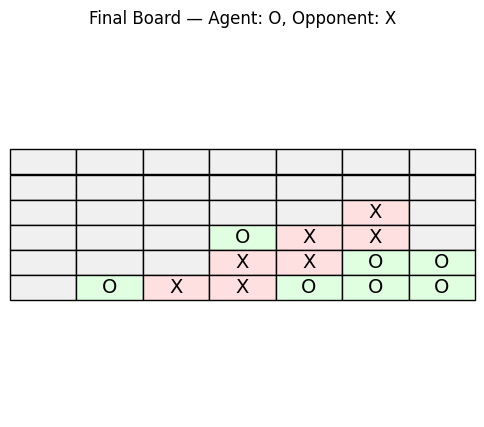

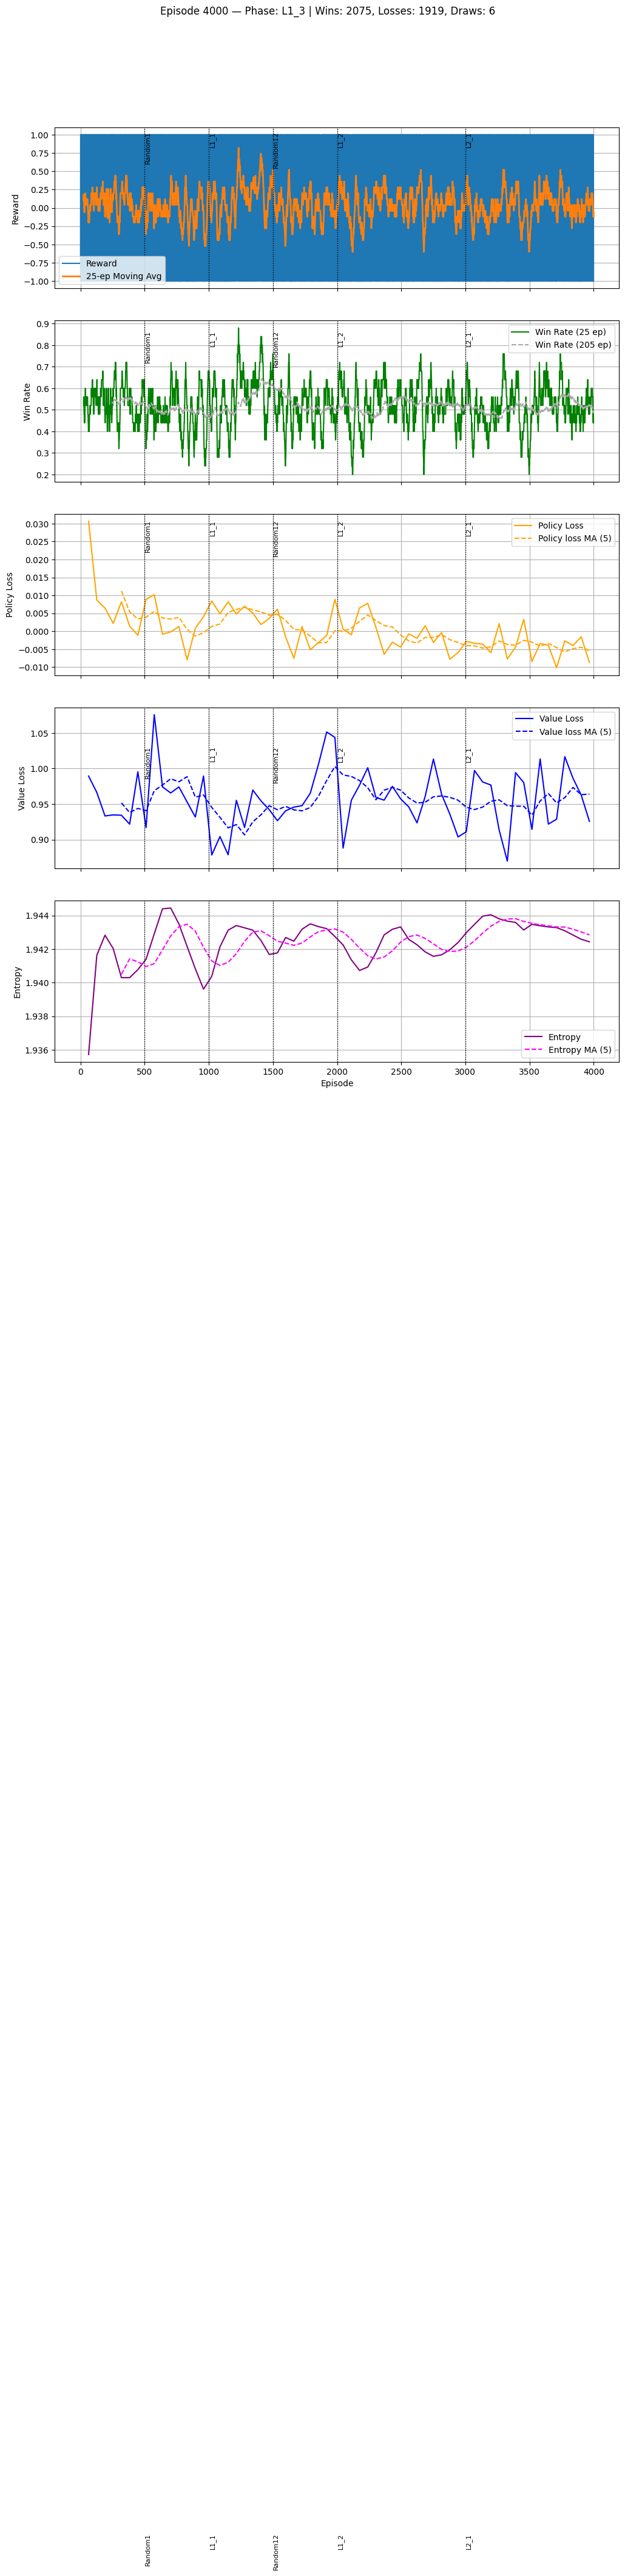

PPO Training: 100%|██████████| 4000/4000 [13:17<00:00,  5.02it/s]


Training completed in 13.3 minutes (0.20 s/episode)


In [14]:
# --- Environment and Model Setup ---
env = Connect4Env()
model = ActorCritic().to(DEVICE)
Learning_rate = 3e-4 
#Learning_rate = 5e-4
#2.5e-4
# or 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)

start_time = time.time()

# --- Train PPO Agent with Curriculum Phases ---
episode_rewards, summary_stats = train_ppo(
    env=env,
    model=model,
    optimizer=optimizer,
    phase_config=TRAINING_PHASES,
    episodes=N_EPISODES,
    batch_size=64
)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / N_EPISODES:.2f} s/episode)")


### Final plot

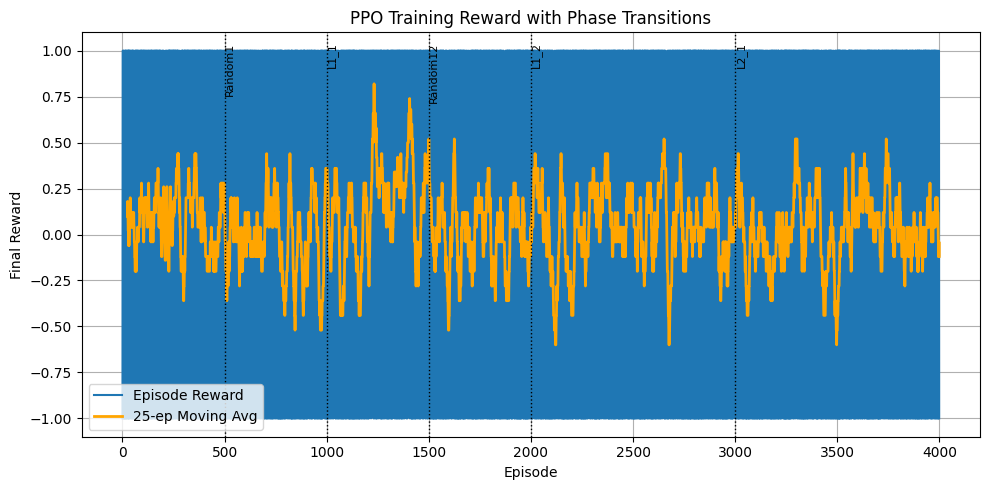

📈 Reward plot saved to: Plots/PPQ/PPQ-PPQ-4000-L2L1_reward_plot.png


In [15]:
# === Plot Training Progress with Phase Transitions ===
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')

# Add moving average
if len(episode_rewards) >= 25:
    avg = np.convolve(episode_rewards, np.ones(25)/25, mode='valid')
    plt.plot(range(24, len(episode_rewards)), avg, label='25-ep Moving Avg', color='orange', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Final Reward')
plt.title('PPO Training Reward with Phase Transitions')
plt.grid(True)
plt.legend()

# Draw vertical phase transitions
for name, cfg in TRAINING_PHASES.items():
    ep = cfg["length"]
    if ep is not None and ep < len(episode_rewards):
        plt.axvline(ep, color='black', linestyle='dotted', linewidth=1)
        plt.text(ep + 2, plt.ylim()[1]*0.95, name, rotation=90, va='top', ha='left', fontsize=8)

plt.tight_layout()
reward_plot_path = f"{PLOTS}PPQ-{TRAINING_SESSION}_reward_plot.png"
plt.savefig(reward_plot_path)
plt.show()

print(f"📈 Reward plot saved to: {reward_plot_path}")

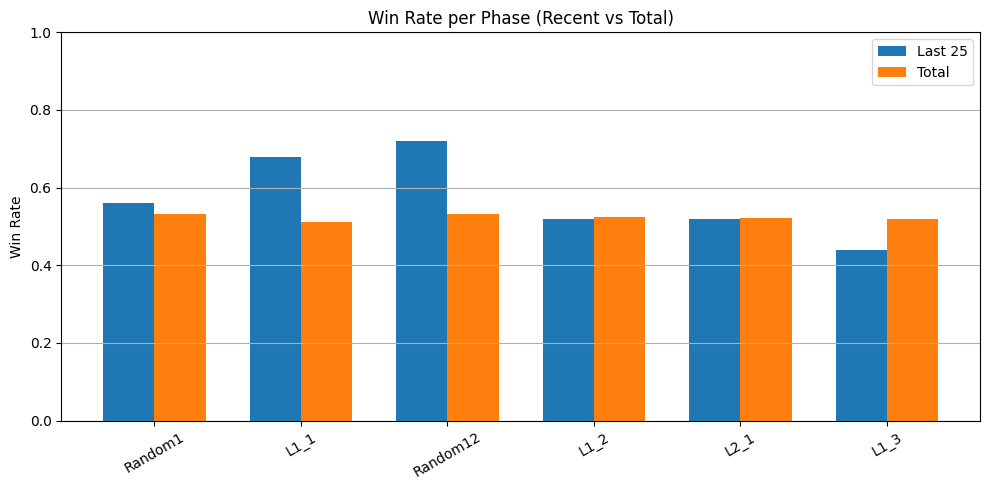

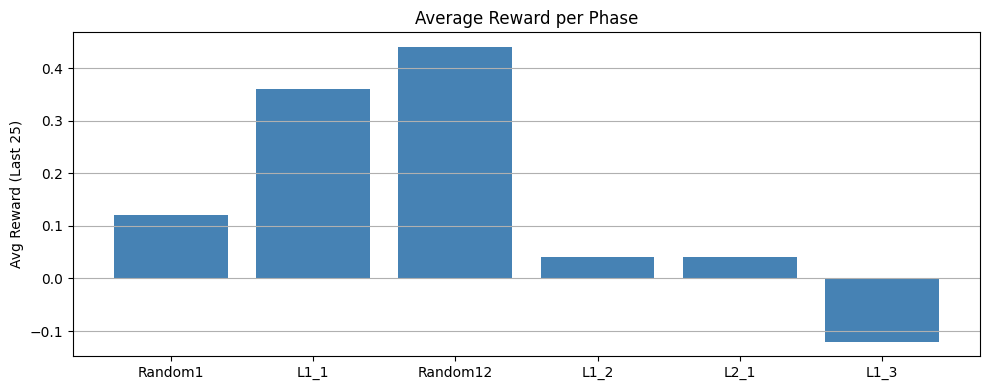

In [16]:
plot_phase_summary(summary_stats)

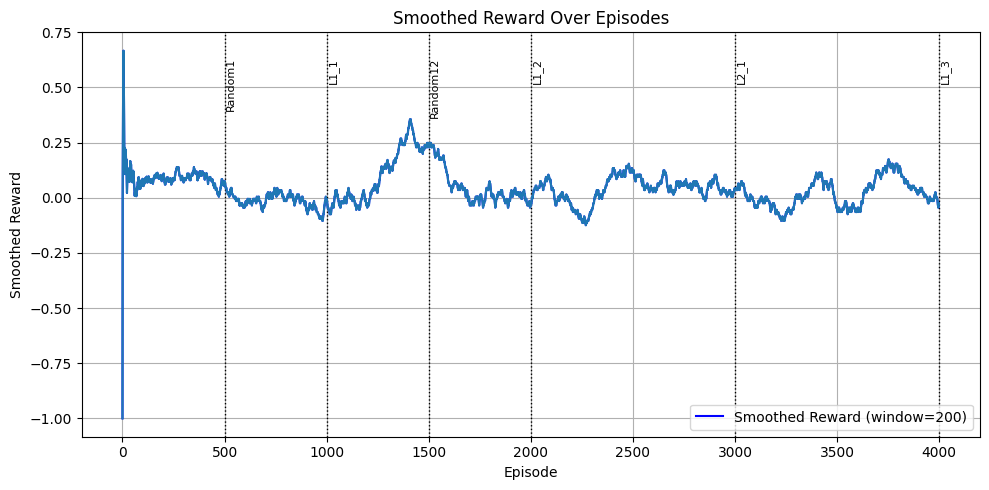

In [17]:
window = 200
smoothed = [np.mean(episode_rewards[max(0, i-window):i+1]) for i in range(len(episode_rewards))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})", color='blue')

# --- Add phase transitions ---
for name, meta in TRAINING_PHASES.items():
    ep = meta["length"]
    if ep is not None and ep <= len(episode_rewards):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, max(smoothed) * 0.95, name,
                             rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()

plt.plot(smoothed)
plt.show()

In [18]:
df_summary = pd.DataFrame.from_dict(summary_stats, orient="index")
df_summary.to_excel(f"{LOG_DIR}PPO-{TRAINING_SESSION}_summary.xlsx", index=True)

## Save model

In [19]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 ppo_model_{timestamp} episodes-{N_EPISODES} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 PPQ model.pt"

torch.save(model.state_dict(), model_path)
torch.save(model.state_dict(), default_model_path)
print(f"Model saved to {model_path}")


Model saved to Models/PPQ/PPQ-4000-L2L1_Connect4 ppo_model_20250807-143957 episodes-4000 lookahead-7.pt


## Reload model

In [20]:
loaded_model = ActorCritic().to(DEVICE)
load_path = default_model_path


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    loaded_model.load_state_dict(torch.load(load_path, map_location=DEVICE))

loaded_model.eval()
print(f"Model successfully loaded from {load_path}")

Model successfully loaded from Connect4 PPQ model.pt


# Evaluation

Opponent: Lookahead-3: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]

Evaluation completed in 0.8 minutes

📊 Evaluation Summary:
Random: 46W / 54L / 0D → Win Rate: 46.0%, Loss: 54.0%, Draws: 0.0%
Lookahead-1: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-2: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-3: 0W / 25L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%


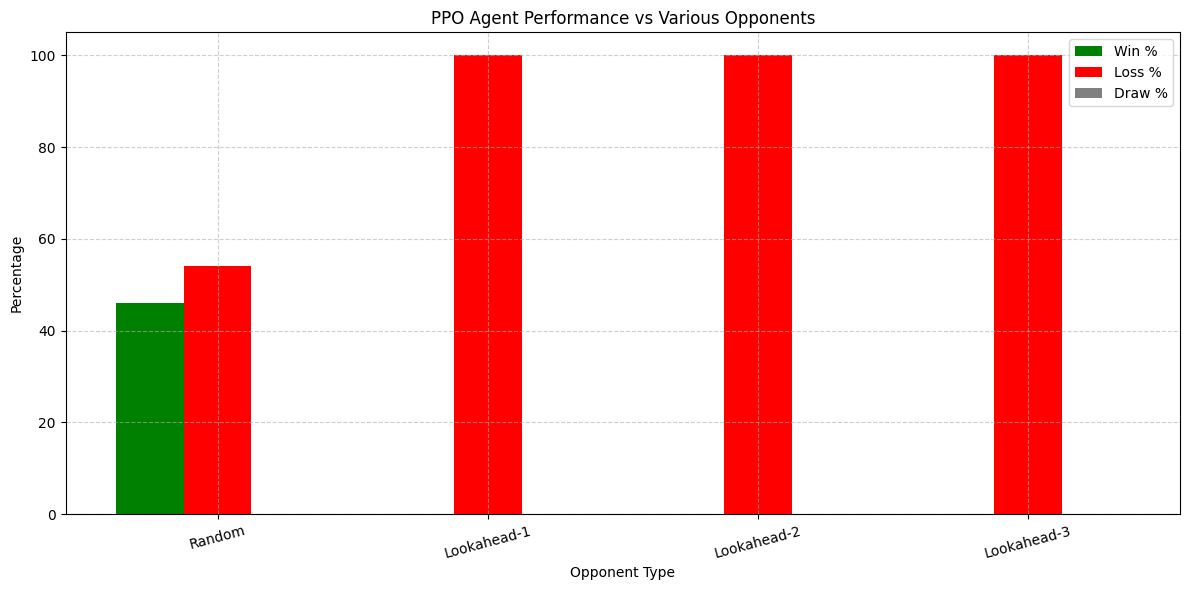

In [21]:
# === EVALUATION CONFIGURATION ===
evaluation_opponents = {
    "Random": 100,
    "Lookahead-1": 100,
    "Lookahead-2": 100,
    "Lookahead-3": 25,
    # "Lookahead-5": 10, # too soon to test
    # "Lookahead-7": 5  # too soon to test
}

evaluation_results = {}
start_time = time.time()


for label, num_games in evaluation_opponents.items():
    wins = losses = draws = 0
    depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

    with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
        for _ in range(num_games):
            state = env.reset()
            done = False
            agent_first = random.choice([True, False])

            while not done:
                if (env.current_player == 1 and agent_first) or (env.current_player == -1 and not agent_first):
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)
                    action, _, _ = loaded_model.act(state_tensor)
                else:
                    if label == "Random":
                        action = random.choice(env.available_actions())
                    else:
                        action = Lookahead.n_step_lookahead(state, env.current_player, depth=depth)

                state, reward, done = env.step(action)

            winner = -env.current_player
            if winner == 1:
                if agent_first:
                    wins += 1
                else:
                    losses += 1
            elif winner == -1:
                if not agent_first:
                    wins += 1
                else:
                    losses += 1
            else:
                draws += 1

            pbar.update(1)

    evaluation_results[label] = {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": round(wins / num_games, 2),
        "loss_rate": round(losses / num_games, 2),
        "draw_rate": round(draws / num_games, 2)
    }

end_time = time.time()
elapsed = end_time - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes")

print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win Rate: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draws: {stats['draw_rate']*100:.1f}%")

labels = list(evaluation_results.keys())
win_rates = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %', color='green')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %', color='red')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %', color='gray')

plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('PPO Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Save evaluation results
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"
df_eval.to_excel(f"{LOG_DIR}{TRAINING_SESSION}_PPO_evaluation_results.xlsx", index=True)

# DONE

In [22]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 0.2 hours


## Training log

In [23]:
# TRAINING_SESSION

training_log_file = "PPO Training_Sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": N_EPISODES}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: PPO Training_Sessions.xlsx
